In [3]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [36]:
# NLTK 패키지의 불용어 사전 다운 & 데이터 전처리를 위한 패키지
nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [38]:
data.sample(10)

,headlines,text
91883,Matrimonial site for cancer patients and survi...,A matrimonial website for blood cancer survivo...
54558,Russia slams US' plan to sell anti-missile sys...,Russia on Thursday slammed the US over its pla...
69728,Pandya's the 2nd most important Gujarati for u...,Reacting to Hardik Pandya's 66-ball 83 against...
41863,Scientist who coined 'Big Bang' had rejected t...,"On March 28, 1949, British astronomer Fred Hoy..."
73549,"After Delhi Airport scare, govt plans law to c...",The Ministry of Home Affairs (MHA) is planning...
46773,Ex-Guj police head 1st to be discharged in Ish...,A CBI court on Wednesday made the first discha...
18671,Twitter doesn't use political ideology for dec...,In a prepared testimony ahead of a congression...
2404,Mazumdar-Shaw re-appointed Infosys' lead indep...,Biocon Chairperson Kiran Mazumdar-Shaw has bee...
73885,50 students hospitalised after gas leak near s...,At least 50 students have been hospitalised af...
41098,Girls turn into women but boys will always be ...,"Alia Bhatt, who received the Most Stylish Woma..."


In [7]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


## 데이터 전처리

#### 중복 데이터

In [8]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [9]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### 결측치 확인

In [10]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [11]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### 텍스트 정규화와 불용어 제거

In [12]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [13]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [14]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [19]:
# text 전처리
data['text'] = data['text'].map(lambda x: preprocess_sentence(x, True))

In [20]:
print("Text 전처리 후 결과: ")
print(data["text"].head)

Text 전처리 후 결과: 
<bound method NDFrame.head of 0        saurav kant alumnus upgrad iiit pg program mac...
1        kunal shah credit card bill payment platform c...
2        new zealand defeated india wickets fourth odi ...
3        aegon life iterm insurance plan customers enjo...
4        speaking sexual harassment allegations rajkuma...
                               ...                        
98396    crpf jawan tuesday axed death sharp edged weap...
98397    uff yeh first song sonakshi sinha starrer upco...
98398    according reports new version science fiction ...
98399    new music video shows rapper snoop dogg aiming...
98400    madhesi morcha alliance seven political partie...
Name: text, Length: 98360, dtype: object>


In [23]:
# headlines 전처리
data['headlines'] = data['headlines'].map(lambda x: preprocess_sentence(x, False))

In [24]:
print("Headlines 전처리 후 결과: ")
print(data["headlines"].head)

Headlines 전처리 후 결과: 
<bound method NDFrame.head of 0        upgrad learner switches to career in ml al wit...
1        delhi techie wins free food from swiggy for on...
2        new zealand end rohit sharma led india match w...
3        aegon life iterm insurance plan helps customer...
4        have known hirani for yrs what if metoo claims...
                               ...                        
98396    crpf jawan axed to death by maoists in chhatti...
98397    first song from sonakshi sinha noor titled uff...
98398                the matrix film to get reboot reports
98399    snoop dogg aims gun at clown dressed as trump ...
98400    madhesi morcha withdraws support to nepalese g...
Name: headlines, Length: 98360, dtype: object>


In [25]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [26]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [27]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


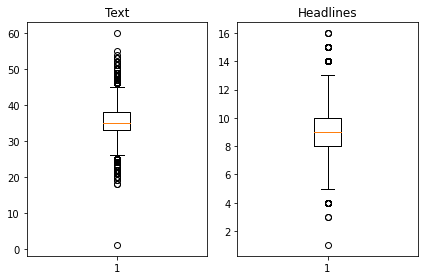

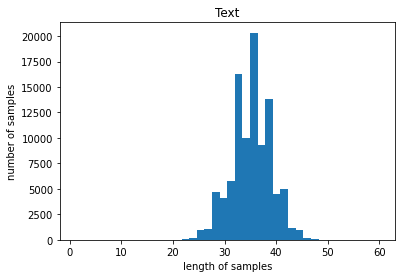

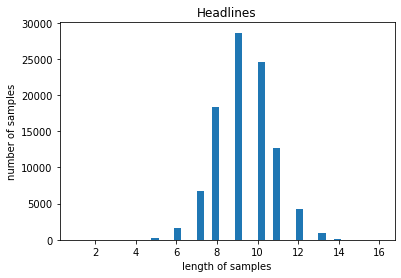

In [28]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
text_max_len = 60
headline_max_len = 16

In [30]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
    print('=3')

In [32]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
=3
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0
=3


In [33]:
# apply(lambda x: len(x["text"])<= text_max_len and len(x["summary"]))
data['text'] = data['text'].apply(lambda x: len(x) <= text_max_len)
data['headlines'] = data['headlines'].apply(lambda x: len(x) <= headline_max_len)

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [35]:
data.head

,headlines,text
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [34]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

TypeError: can only concatenate str (not "bool") to str

## 어텐션 메커니즘

## 실제결과와 요약문 비교

## Summa을 이용해서 추출적 요약해보기